# 1. 引用项目所需要的包

In [5]:
#!/usr/bin/python3.5  
# -*- coding: utf-8 -*-  
import os
import shutil
import time
import sys
import math

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg # mpimg 用于读取图片
import PIL

from keras.models import Model, load_model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

from keras.applications.xception import Xception
from keras.applications.xception import preprocess_input, decode_predictions

from IPython.display import Image
from IPython.core.display import HTML 

# 2. 数据集的处理
## 2.1 数据集目录的处理
由于训练集里的数据是放在一个目录下的，可以考虑图片分类放到相应的目录中，即文件名包含“cat”放到0目录下，文件名包含“dog”放到1目录下, 便于Keras的获取分类值。(注：Keras会根据train, validataion目录下的子目录名自动定义分类)

In [6]:
root_train_dir = "train"
root_test_dir = "test"

train_dir = "new_train"
val_dir = "val"
cat_train_dir = train_dir + "/0" # 0 is the lable for cat image
cat_val_dir = val_dir + "/0"
dog_train_dir = train_dir+"/1" # 1 is the lable for dog image
dog_val_dir = val_dir + "/1"

sample_size = 100      #include training sample and validation sample
val_sample_size = 20  # sample size of validation data 
image_w, image_h = 299, 299  # the input impage size of width and heighth
batch_size = 50
nn_classes = 1  


def create_train_dir(source_train_dir, new_train_dir, keyword_in_name, max_num=0, oper_type=0,):
    '''
     create a dir for train dataset
         
    '''       
    if max_num > 0:
        counter = 0     
        if os.path.exists(new_train_dir): 
            shutil.rmtree(new_train_dir)

        os.makedirs(new_train_dir)
        
        for root, dirs, files in os.walk(source_train_dir):
            for afile in files:
                if keyword_in_name in afile:
                    sourcepath = source_train_dir + "/" + afile
                    targetpath= new_train_dir + "/" + afile
                    if oper_type==0: #copy file
                        shutil.copyfile(sourcepath, targetpath)
                    elif oper_type == 1: # move file
                        shutil.move(sourcepath, targetpath)
#                     print("counter is {0}, filename is {1}".format(counter, afile))
                    counter = counter + 1                
                    if max_num > 0 :
                        if counter >= max_num:
                            print("Done")
                            return 

In [7]:
#Create the train and val sub diretories, train, each dir has 2 sub dirs which are 0(cat) & 1(dog)
create_train_dir(root_train_dir, cat_train_dir, "cat",sample_size, 0)
create_train_dir(cat_train_dir, cat_val_dir, "cat", val_sample_size, 1)
create_train_dir(root_train_dir, dog_train_dir, "dog",sample_size, 0) 
create_train_dir(dog_train_dir, dog_val_dir, "dog", val_sample_size, 1)   

Done
Done
Done
Done


# 使用base model来寻找潜在的Outlier
find out all outliers in the train data set, and store their image id into a list.

In [8]:
# create the base model with top
start= time.time()
base_model=Xception(weights='imagenet')
end = time.time()
print("Buildup NN:", end-start)

Buildup NN: 12.26901912689209


In [9]:
# load the id of cat/dog images which specified in ImageNet from a text to a list 
def load_ImageNet_ids(filepath):
    with open(filepath) as fp:
        arr=[]
        for line in fp.readlines():
            arr.append(line.strip())
    return arr


In [10]:
# tell if the target image id is in the Imagenet id list.
def is_outlier(target_ids, imagenet_id_list):
    for target_id in target_ids:
        if target_id[0] in imagenet_id_list:
#             print(target_id[1])
            return False     
    return True

In [11]:
# display the images withe specified image size.
def visual_images(files, image_size):
   
    get_ipython().magic('matplotlib inline')
    
    images =[image.load_img(path, target_size =image_size) for path in files]
    images = [image.img_to_array(img) for img in images]
    images = np.array(images).astype(np.uint8)
    
    batches = math.ceil(len(images)*1.0/8)
    
    print(batches)
    images = images[0:batches*8]
    fig = plt.figure(figsize=(30,30))
    for i in range(1, 8*batches+1 ):
        if i-1 < len(files):
            fig.add_subplot(batches, 8, i)
            plt.xlabel(os.path.basename(files[i-1]))
            plt.imshow(images[i-1])
    plt.show()

In [12]:
# Load the id list of cat/dog from text file to a list
imagenet_cat_ids = load_ImageNet_ids("cat.txt")
imagenet_dog_ids = load_ImageNet_ids("dog.txt")

In [17]:
# x = len('hello')
# print("{:>15} is:\t{}".format("he", "cat"))
# print("{:>15} is:\t{}".format("hello", "dog"))
print(len(cat_outliers))


TypeError: object of type 'NoneType' has no len()

In [19]:
# pre process the input
def find_outliers(data_dir, ids_in_imagenet, top):
    outliers=[]
    for (root, dir, files) in os.walk(data_dir):
        for afile in files:

            image_path = data_dir + "/" + afile
            img = image.load_img(image_path, target_size=(image_w,image_h))
            x = image.img_to_array(img)  
            x = np.expand_dims(x, axis=0) # I am not clear why need to expand the dim with axis=0
            x = preprocess_input(x)
            preds = base_model.predict(x) 
            pre_id = decode_predictions(preds, top)[0]  
    #             print(pre_id)
            result = is_outlier(pre_id, ids_in_imagenet)
            if result:
                outliers.append(image_path)
    #         print ('The image {:^15} : \t {}'.format(afile, result))     
    return outliers

In [22]:
# find out outliers in cat images
start= time.time()
cat_outliers = find_outliers(cat_train_dir, imagenet_cat_ids, 130)
end = time.time()
print("The duration of outlier searching: {}, and {} outliers are found".format(end-start, len(cat_outliers) ))


The duration of outlier searching: 121.22953295707703, and 1 outliers are found


1


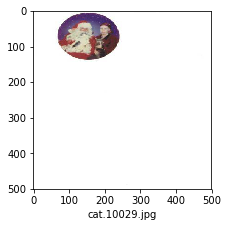

In [21]:
# display all outliers, observe if there is any fake outliers, if so, adjust the top value accordingly in function find_outliers()
visual_images(cat_outliers, (500,500))   

In [23]:
# find out outliers in dog images 
start= time.time()
dog_outliers = find_outliers(dog_train_dir, imagenet_dog_ids, top=40)
end = time.time()
print("The duration of outlier searching: {}, and {} outliers are found".format(end-start, len(dog_outliers) ))

The duration of outlier searching: 116.97860503196716, and 0 outliers are found


In [ ]:
# display all outliers in dog images to see if there any fake outliers.
visual_images(dog_outliers, (500,500))  

In [ ]:
# Remove the outliers


## 创建训练集和验证集的Generator
1. 训练集从cat，dog目录中生成图片生成器

In [24]:
train_data_gen = ImageDataGenerator()
val_data_gen = ImageDataGenerator()

train_gen = train_data_gen.flow_from_directory(
    train_dir,
    target_size=(image_w, image_h),
    batch_size=batch_size,
    class_mode="binary"
)

valid_gen = val_data_gen.flow_from_directory(
    val_dir,
    target_size=(image_w, image_h),
    batch_size=batch_size,
    class_mode="binary"
)


Found 160 images belonging to 2 classes.
Found 40 images belonging to 2 classes.


## 定义网络架构

In [26]:
def add_new_top_layers(base_model, nn_classes):
    '''
    create new layers onto a base model
    '''
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation="relu", name="my_fc1")(x)
    predictions = Dense(nn_classes, activation='softmax', name="my_output")(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    
    return model

In [29]:
base_model=Xception(weights='imagenet', include_top=False)
model = add_new_top_layers(base_model, nn_classes)

#freeze all layers of base model
for layer in base_model.layers:
    layer.trainable = False

In [30]:
model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=['accuracy'])
# model.summary()

In [31]:
print("base_model layers:", len(base_model.layers))
print("model layers:", len(model.layers))
# print(my_model.fit_generator(train_gen).__doc__)

base_model layers: 132
model layers: 135


## 训练模型

直接训练新层

In [32]:
start= time.time()
train1 = model.fit_generator(
    train_gen,
    steps_per_epoch=2,
    epochs = 1,
    verbose = 2,
    validation_data=valid_gen,
    validation_steps=2,   
)
end = time.time()
print("Trainning Time:", end-start)

Epoch 1/1
 - 224s - loss: 7.8118 - acc: 0.5100 - val_loss: 7.9712 - val_acc: 0.5000
Trainning Time: 224.38235688209534


In [33]:
type(train1.history)
print(train1.history['acc'])

[0.54999998708566034]


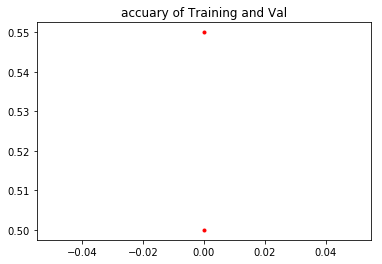

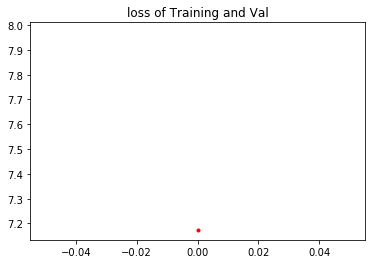

In [34]:
def plot_training(model):
    train_acc = model.history['acc']
    val_acc = model.history['val_acc']
    train_loss = model.history['loss']
    val_loss = model.history['val_loss']
    epochs = range(len(train_acc))
    
    plt.plot(epochs, train_acc, 'r.')
    plt.plot(epochs, val_acc, 'r.')
    plt.title('accuary of Training and Val')
    plt.figure()
    plt.plot(epochs, train_loss, 'r.')
    plt.plot(epochs, val_loss, 'r-')
    plt.title('loss of Training and Val')
    plt.show()

plot_training(train1)

## Fine-Tunning 模式2
只冻结除base-model最后一个block层的其他所有层，训练最后一个block层及新层, 并使用低学习率来微调

In [35]:
NN_LAST_BLOCK_LAYERS = 126
for layer in model.layers[:NN_LAST_BLOCK_LAYERS]:
   layer.trainable = False
for layer in model.layers[NN_LAST_BLOCK_LAYERS:]:
   layer.trainable = True


In [37]:
from keras.optimizers import SGD
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='binary_crossentropy') #0.9 means ten times optimize momentum

In [38]:
# train the new model
start= time.time()
train2 = model.fit_generator(
    train_gen,
    steps_per_epoch=2,
    epochs = 1,
    verbose = 2,
    validation_data=valid_gen,
    validation_steps=2,  
)

end = time.time()
print("Training spent:", end-start)

Epoch 1/1
 - 293s - loss: 8.4495 - val_loss: 7.9712
Training spent: 293.85145330429077


In [ ]:
plot_training(train2) 

In [81]:
a=np.array([1,2,3,4,5])
a[:3]
a[3:]

array([4, 5])

## 参数优化各种研究方案
可以考虑以下几种方案：
1. Early Stopping: 训练集中使用earlystopping, 当验证准确率经过几轮后，不再提高，则可以尽早自动停止，防止进行更多不要的计算。
2. 数据集扩增（Data augmentation）
3. 正则化（Regularization）
4. Dropout:
5. ...

In [ ]:
import keras.callbacks  
keras.callbacks.EarlyStopping(monitor='val_loss', patience=0, verbose=0, mode='auto')  

## 预测

In [116]:
#Load a dataset
img_path = 'test/122.jpg'
img = image.load_img(img_path, target_size=(image_w,image_h))
x = np.expand_dims(img, axis=0)



In [111]:
print(x.flags)
x.setflags(write=1)
print(x.flags)

  C_CONTIGUOUS : True
  F_CONTIGUOUS : False
  OWNDATA : False
  WRITEABLE : False
  ALIGNED : True
  WRITEBACKIFCOPY : False
  UPDATEIFCOPY : False
  C_CONTIGUOUS : True
  F_CONTIGUOUS : False
  OWNDATA : False
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False
  UPDATEIFCOPY : False


[[1.]]


In [117]:
 # I am not clear why need to expand the dim with axis=0
# x = preprocess_input(x)
preds = model.predict(x)
print(preds)

In [ ]:
%debug

In [ ]:
l = [1,3,5,6]
len(l)
a =1
if a=1:
    print("ok")